# Keyword Experiment: Top Words vs Paper Discovery

## Objective
This experiment investigates the relationship between the number of top keywords used in ADS searches and the discovery of relevant papers. We will test different numbers of top words (2, 3, 4, 5, 10) and analyze:

1. **Number of papers found** for each keyword count
2. **Overlap percentage** with WUMaCat database
3. **Optimal keyword count** for discovery vs precision

## Methodology
- Extract top N words from wordcloud analysis (titles + abstracts)
- For each N ∈ {2, 3, 4, 5, 10}:
  - Count total papers found
  - Retrieve all bibcodes
  - Compare with WUMaCat bibcodes
  - Calculate overlap percentage
- Visualize results with graphs

## Expected Outcomes
- **More keywords** → More papers found (broader search)
- **Fewer keywords** → Higher precision/overlap with WUMaCat
- Find optimal balance between discovery and relevance


## Setup and Imports


In [1]:
# Setup and imports
import sys
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Add the src directory to the path
sys.path.append('../src')

# Import our custom modules
from wordcloud_utils import extract_top_words_from_json_files
from ads_parser import (
    test_ads_connection,
    count_publications_for_keywords,
    search_all_bibcodes
)

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully")
print("✅ Ready to start keyword experiment!")


✅ Libraries imported successfully
✅ Ready to start keyword experiment!


## Step 1: Test ADS Connection & Load Data


In [2]:
# Test ADS API connection
print("🚀 Testing ADS API connection...")
connection_ok = test_ads_connection()

if connection_ok:
    print("✅ ADS connection successful! Ready to proceed.")
else:
    print("❌ ADS connection failed. Please check your API token in .env file.")
    print("You can get an ADS API token from: https://ui.adsabs.harvard.edu/user/settings/token")

# Load WUMaCat data
print("\n📂 Loading WUMaCat baseline data...")
wumacat_file = '../data/WUMaCat.csv'

if os.path.exists(wumacat_file):
    wumacat_df = pd.read_csv(wumacat_file)
    wumacat_bibcodes = set(wumacat_df['Bibcode'].dropna().unique())
    print(f"✅ Loaded WUMaCat.csv")
    print(f"📊 Total unique bibcodes in WUMaCat: {len(wumacat_bibcodes):,}")
else:
    print(f"❌ WUMaCat file not found: {wumacat_file}")
    wumacat_bibcodes = set()


🚀 Testing ADS API connection...
🔍 Testing ADS API connection...
✅ ADS API connection successful!
   Found 1103 total results
   Retrieved 1 documents
✅ ADS connection successful! Ready to proceed.

📂 Loading WUMaCat baseline data...
✅ Loaded WUMaCat.csv
📊 Total unique bibcodes in WUMaCat: 424


## Step 2: Extract Different Keyword Sets


In [3]:
# Extract keyword sets for the experiment
print("📊 Extracting keyword sets from wordcloud analysis...")

titles_freq_file = '../wordclouds/titles_word_frequencies.json'
abstracts_freq_file = '../wordclouds/abstracts_word_frequencies.json'

# Check if the wordcloud files exist
if not os.path.exists(titles_freq_file) or not os.path.exists(abstracts_freq_file):
    print("❌ Wordcloud frequency files not found!")
    print("Please run the wordcloud_analysis.ipynb notebook first to generate the frequency data.")
    print(f"Looking for:")
    print(f"  - {titles_freq_file}")
    print(f"  - {abstracts_freq_file}")
    experiment_keywords = {}
else:
    # Define the numbers of keywords to test
    keyword_counts = [2, 3, 4, 5, 10]
    experiment_keywords = {}
    
    print(f"\n📝 Extracting keyword sets for experiment:")
    print(f"Testing with: {keyword_counts} top words")
    
    for n in keyword_counts:
        keywords = extract_top_words_from_json_files(titles_freq_file, abstracts_freq_file, n)
        experiment_keywords[n] = keywords
        print(f"  Top {n:2d} keywords ({len(keywords):2d} unique): {keywords}")
    
    print(f"\n✅ Successfully extracted {len(experiment_keywords)} keyword sets")


📊 Extracting keyword sets from wordcloud analysis...

📝 Extracting keyword sets for experiment:
Testing with: [2, 3, 4, 5, 10] top words
  Top  2 keywords ( 4 unique): ['light', 'binary', 'period', 'photometric']
  Top  3 keywords ( 5 unique): ['photometric', 'light', 'contact', 'binary', 'period']
  Top  4 keywords ( 6 unique): ['photometric', 'light', 'eclipsing', 'contact', 'binary', 'period']
  Top  5 keywords ( 8 unique): ['mass', 'photometric', 'light', 'period', 'eclipsing', 'contact', 'binary', 'uma']
  Top 10 keywords (13 unique): ['mass', 'orbital', 'photometric', 'period', 'light', 'type', 'eclipsing', 'contact', 'system', 'binary', 'binaries', 'curves', 'uma']

✅ Successfully extracted 5 keyword sets


## Step 3: Count Papers for Each Keyword Set


In [4]:
# Count papers for each keyword set
print("🔢 EXPERIMENT: Counting papers for different keyword counts")
print("="*70)

paper_counts = {}
search_field = "full"  # Use full text search

if experiment_keywords:
    for n in sorted(experiment_keywords.keys()):
        keywords = experiment_keywords[n]
        
        print(f"\n📊 Testing {n} keywords: {keywords}")
        
        # Count papers (silent mode to reduce output)
        count = count_publications_for_keywords(
            keywords, 
            search_fields=search_field, 
            description=f"{n} keywords",
            silent=True
        )
        
        paper_counts[n] = count
        print(f"   ✅ Found {count:,} papers")
    
    # Display summary
    print(f"\n📋 PAPER COUNT SUMMARY:")
    print("="*40)
    for n in sorted(paper_counts.keys()):
        print(f"  {n:2d} keywords: {paper_counts[n]:6,} papers")
    
    # Show trend
    if len(paper_counts) > 1:
        max_count = max(paper_counts.values())
        min_count = min(paper_counts.values())
        print(f"\n📈 TREND ANALYSIS:")
        print(f"  Range: {min_count:,} to {max_count:,} papers")
        print(f"  Ratio: {max_count/min_count:.1f}x difference between min and max")
        
else:
    print("❌ No keyword sets available for counting")
    paper_counts = {}


🔢 EXPERIMENT: Counting papers for different keyword counts

📊 Testing 2 keywords: ['light', 'binary', 'period', 'photometric']
🔍 Searching for: full:light AND full:binary AND full:period AND full:photometric
✅ Found 67312 papers, retrieved 1
   ✅ Found 67,312 papers

📊 Testing 3 keywords: ['photometric', 'light', 'contact', 'binary', 'period']
🔍 Searching for: full:photometric AND full:light AND full:contact AND full:binary AND full:period
✅ Found 12660 papers, retrieved 1
   ✅ Found 12,660 papers

📊 Testing 4 keywords: ['photometric', 'light', 'eclipsing', 'contact', 'binary', 'period']
🔍 Searching for: full:photometric AND full:light AND full:eclipsing AND full:contact AND full:binary AND full:period
✅ Found 9425 papers, retrieved 1
   ✅ Found 9,425 papers

📊 Testing 5 keywords: ['mass', 'photometric', 'light', 'period', 'eclipsing', 'contact', 'binary', 'uma']
🔍 Searching for: full:mass AND full:photometric AND full:light AND full:period AND full:eclipsing AND full:contact AND full:

## Step 4: Retrieve Bibcodes for Each Keyword Set


In [5]:
# Retrieve all bibcodes for each keyword set
print("📥 EXPERIMENT: Retrieving bibcodes for each keyword set")
print("="*70)

experiment_bibcodes = {}

if experiment_keywords and paper_counts:
    for n in sorted(experiment_keywords.keys()):
        keywords = experiment_keywords[n]
        expected_count = paper_counts[n]
        
        print(f"\n🔍 Retrieving bibcodes for {n} keywords ({expected_count:,} papers expected)")
        print(f"   Keywords: {keywords}")
        
        # Retrieve all bibcodes (silent mode to reduce output)
        bibcodes = search_all_bibcodes(
            keywords, 
            search_fields=search_field,
            silent=True  # Keep it quiet for the experiment
        )
        
        experiment_bibcodes[n] = bibcodes
        print(f"   ✅ Retrieved {len(bibcodes):,} bibcodes")
        
        # Verify count matches expectation
        if len(bibcodes) != expected_count:
            diff = abs(len(bibcodes) - expected_count)
            print(f"   ⚠️  Count difference: {diff} (expected {expected_count:,}, got {len(bibcodes):,})")
    
    # Summary of retrieved bibcodes
    print(f"\n📋 BIBCODE RETRIEVAL SUMMARY:")
    print("="*50)
    total_api_requests = 0
    for n in sorted(experiment_bibcodes.keys()):
        count = len(experiment_bibcodes[n])
        # Estimate API requests used (rough calculation)
        requests_used = max(1, (count + 1999) // 2000) + 1  # +1 for initial count
        total_api_requests += requests_used
        print(f"  {n:2d} keywords: {count:6,} bibcodes (≈{requests_used} API requests)")
    
    print(f"\n📊 Total estimated API requests used: {total_api_requests}")
    
else:
    print("❌ No keyword sets or paper counts available")
    experiment_bibcodes = {}


📥 EXPERIMENT: Retrieving bibcodes for each keyword set

🔍 Retrieving bibcodes for 2 keywords (67,312 papers expected)
   Keywords: ['light', 'binary', 'period', 'photometric']
   ✅ Retrieved 67,312 bibcodes

🔍 Retrieving bibcodes for 3 keywords (12,660 papers expected)
   Keywords: ['photometric', 'light', 'contact', 'binary', 'period']
   ✅ Retrieved 12,660 bibcodes

🔍 Retrieving bibcodes for 4 keywords (9,425 papers expected)
   Keywords: ['photometric', 'light', 'eclipsing', 'contact', 'binary', 'period']
   ✅ Retrieved 9,425 bibcodes

🔍 Retrieving bibcodes for 5 keywords (3,402 papers expected)
   Keywords: ['mass', 'photometric', 'light', 'period', 'eclipsing', 'contact', 'binary', 'uma']
   ✅ Retrieved 3,402 bibcodes

🔍 Retrieving bibcodes for 10 keywords (3,066 papers expected)
   Keywords: ['mass', 'orbital', 'photometric', 'period', 'light', 'type', 'eclipsing', 'contact', 'system', 'binary', 'binaries', 'curves', 'uma']
   ✅ Retrieved 3,066 bibcodes

📋 BIBCODE RETRIEVAL SUMMA

## Step 5: Compare with WUMaCat and Calculate Overlap


In [6]:
# Compare each keyword set with WUMaCat
print("🔍 EXPERIMENT: Comparing with WUMaCat database")
print("="*70)

experiment_results = {}

if experiment_bibcodes and wumacat_bibcodes:
    wumacat_count = len(wumacat_bibcodes)
    print(f"📚 WUMaCat baseline: {wumacat_count:,} bibcodes")
    
    for n in sorted(experiment_bibcodes.keys()):
        bibcodes = experiment_bibcodes[n]
        bibcodes_set = set(bibcodes)
        
        # Calculate overlaps
        overlap = bibcodes_set.intersection(wumacat_bibcodes)
        ads_only = bibcodes_set - wumacat_bibcodes
        wumacat_only = wumacat_bibcodes - bibcodes_set
        
        # Calculate percentages
        overlap_pct = (len(overlap) / len(bibcodes_set)) * 100 if bibcodes_set else 0
        coverage_pct = (len(overlap) / wumacat_count) * 100 if wumacat_count > 0 else 0
        
        # Store results
        experiment_results[n] = {
            'keywords': experiment_keywords[n],
            'total_papers': len(bibcodes),
            'overlap_count': len(overlap),
            'overlap_percentage': overlap_pct,
            'coverage_percentage': coverage_pct,
            'new_discoveries': len(ads_only),
            'missed_wumacat': len(wumacat_only)
        }
        
        print(f"\n📊 {n} keywords analysis:")
        print(f"   Total papers found:    {len(bibcodes):6,}")
        print(f"   Overlap with WUMaCat:  {len(overlap):6,} ({overlap_pct:5.1f}%)")
        print(f"   WUMaCat coverage:      {coverage_pct:5.1f}% ({len(overlap):,}/{wumacat_count:,})")
        print(f"   New discoveries:       {len(ads_only):6,}")
    
    # Create summary table
    print(f"\n📋 EXPERIMENT RESULTS SUMMARY:")
    print("="*80)
    print(f"{'Keywords':<10} {'Papers':<8} {'Overlap':<8} {'Overlap%':<9} {'Coverage%':<10} {'New':<8}")
    print("-" * 80)
    
    for n in sorted(experiment_results.keys()):
        r = experiment_results[n]
        print(f"{n:<10} {r['total_papers']:<8,} {r['overlap_count']:<8,} "
              f"{r['overlap_percentage']:<8.1f}% {r['coverage_percentage']:<9.1f}% {r['new_discoveries']:<8,}")
    
else:
    print("❌ Cannot perform comparison - missing data")
    experiment_results = {}


🔍 EXPERIMENT: Comparing with WUMaCat database
📚 WUMaCat baseline: 424 bibcodes

📊 2 keywords analysis:
   Total papers found:    67,312
   Overlap with WUMaCat:     372 (  0.6%)
   WUMaCat coverage:       87.7% (372/424)
   New discoveries:       66,940

📊 3 keywords analysis:
   Total papers found:    12,660
   Overlap with WUMaCat:     371 (  2.9%)
   WUMaCat coverage:       87.5% (371/424)
   New discoveries:       12,289

📊 4 keywords analysis:
   Total papers found:     9,425
   Overlap with WUMaCat:     366 (  3.9%)
   WUMaCat coverage:       86.3% (366/424)
   New discoveries:        9,059

📊 5 keywords analysis:
   Total papers found:     3,402
   Overlap with WUMaCat:     316 (  9.3%)
   WUMaCat coverage:       74.5% (316/424)
   New discoveries:        3,086

📊 10 keywords analysis:
   Total papers found:     3,066
   Overlap with WUMaCat:     301 (  9.8%)
   WUMaCat coverage:       71.0% (301/424)
   New discoveries:        2,765

📋 EXPERIMENT RESULTS SUMMARY:
Keywords   Pap

## Step 6: Create Visualizations


📊 Creating visualizations of experiment results...
✅ Visualizations saved to: ../data/keyword_experiment_results.png


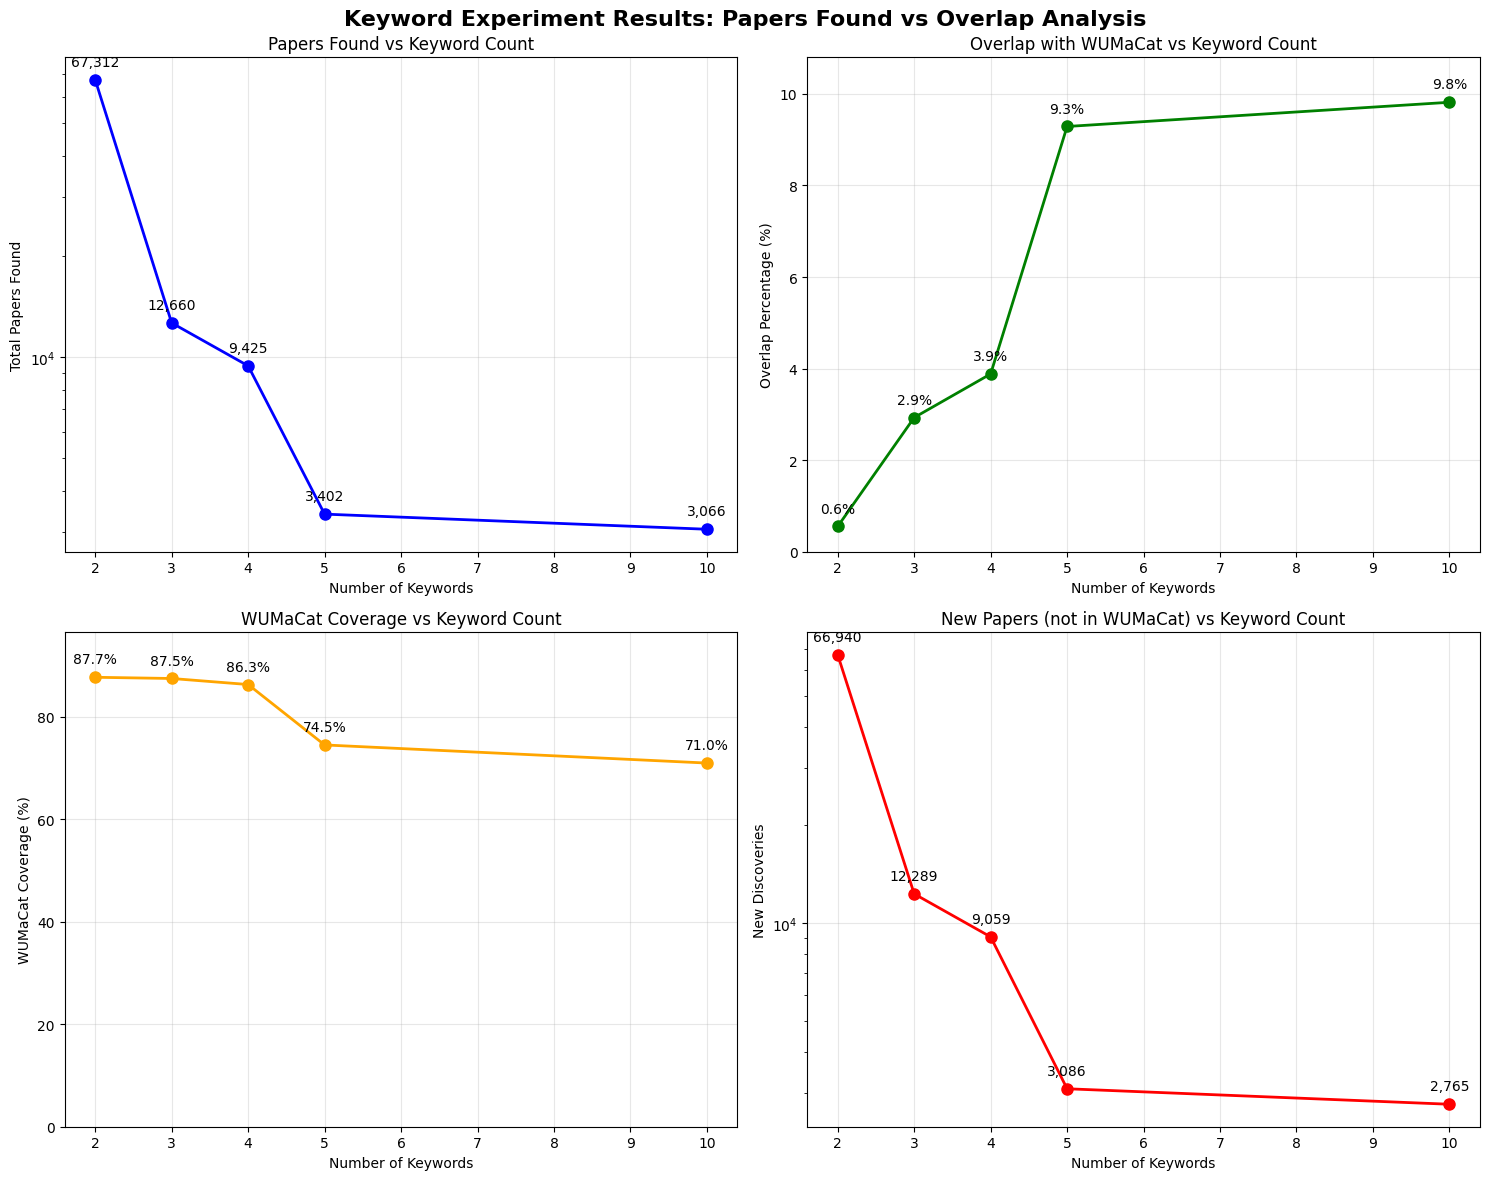

In [7]:
# Create visualizations of the experiment results
print("📊 Creating visualizations of experiment results...")

if experiment_results:
    # Prepare data for plotting
    keyword_counts = sorted(experiment_results.keys())
    total_papers = [experiment_results[n]['total_papers'] for n in keyword_counts]
    overlap_percentages = [experiment_results[n]['overlap_percentage'] for n in keyword_counts]
    coverage_percentages = [experiment_results[n]['coverage_percentage'] for n in keyword_counts]
    new_discoveries = [experiment_results[n]['new_discoveries'] for n in keyword_counts]
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Keyword Experiment Results: Papers Found vs Overlap Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Number of papers found vs keyword count
    ax1.plot(keyword_counts, total_papers, 'o-', linewidth=2, markersize=8, color='blue')
    ax1.set_xlabel('Number of Keywords')
    ax1.set_ylabel('Total Papers Found')
    ax1.set_title('Papers Found vs Keyword Count')
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')  # Log scale for better visualization
    
    # Add value labels
    for i, (x, y) in enumerate(zip(keyword_counts, total_papers)):
        ax1.annotate(f'{y:,}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Plot 2: Overlap percentage vs keyword count
    ax2.plot(keyword_counts, overlap_percentages, 'o-', linewidth=2, markersize=8, color='green')
    ax2.set_xlabel('Number of Keywords')
    ax2.set_ylabel('Overlap Percentage (%)')
    ax2.set_title('Overlap with WUMaCat vs Keyword Count')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, max(overlap_percentages) * 1.1)
    
    # Add value labels
    for i, (x, y) in enumerate(zip(keyword_counts, overlap_percentages)):
        ax2.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Plot 3: WUMaCat coverage vs keyword count
    ax3.plot(keyword_counts, coverage_percentages, 'o-', linewidth=2, markersize=8, color='orange')
    ax3.set_xlabel('Number of Keywords')
    ax3.set_ylabel('WUMaCat Coverage (%)')
    ax3.set_title('WUMaCat Coverage vs Keyword Count')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, max(coverage_percentages) * 1.1)
    
    # Add value labels
    for i, (x, y) in enumerate(zip(keyword_counts, coverage_percentages)):
        ax3.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Plot 4: New discoveries vs keyword count
    ax4.plot(keyword_counts, new_discoveries, 'o-', linewidth=2, markersize=8, color='red')
    ax4.set_xlabel('Number of Keywords')
    ax4.set_ylabel('New Discoveries')
    ax4.set_title('New Papers (not in WUMaCat) vs Keyword Count')
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')  # Log scale for better visualization
    
    # Add value labels
    for i, (x, y) in enumerate(zip(keyword_counts, new_discoveries)):
        ax4.annotate(f'{y:,}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.tight_layout()
    
    # Save the figure
    output_file = '../data/keyword_experiment_results.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ Visualizations saved to: {output_file}")
    
    plt.show()
    
else:
    print("❌ No experiment results available for visualization")


## Step 7: Save Experiment Results


In [8]:
# Save all experiment results to JSON file
print("💾 Saving experiment results...")

if experiment_results:
    # Prepare comprehensive results data
    experiment_data = {
        'metadata': {
            'experiment_date': pd.Timestamp.now().isoformat(),
            'search_field': search_field,
            'wumacat_baseline': len(wumacat_bibcodes) if wumacat_bibcodes else 0,
            'keyword_counts_tested': sorted(experiment_results.keys()),
            'total_api_requests_estimated': sum(
                max(1, (experiment_results[n]['total_papers'] + 1999) // 2000) + 1 
                for n in experiment_results.keys()
            )
        },
        'results': {}
    }
    
    # Add detailed results for each keyword count
    for n in sorted(experiment_results.keys()):
        result = experiment_results[n].copy()
        # Add the actual bibcodes for reference (first 10 only to save space)
        if n in experiment_bibcodes:
            result['sample_bibcodes'] = experiment_bibcodes[n][:10]
        experiment_data['results'][str(n)] = result
    
    # Save to JSON file
    results_file = '../data/keyword_experiment_results.json'
    with open(results_file, 'w', encoding='utf-8') as f:
        json.dump(experiment_data, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Complete experiment results saved to: {results_file}")
    
    # Also save a CSV summary for easy analysis
    summary_df = pd.DataFrame({
        'Keywords': sorted(experiment_results.keys()),
        'Total_Papers': [experiment_results[n]['total_papers'] for n in sorted(experiment_results.keys())],
        'Overlap_Count': [experiment_results[n]['overlap_count'] for n in sorted(experiment_results.keys())],
        'Overlap_Percentage': [experiment_results[n]['overlap_percentage'] for n in sorted(experiment_results.keys())],
        'Coverage_Percentage': [experiment_results[n]['coverage_percentage'] for n in sorted(experiment_results.keys())],
        'New_Discoveries': [experiment_results[n]['new_discoveries'] for n in sorted(experiment_results.keys())]
    })
    
    csv_file = '../data/keyword_experiment_summary.csv'
    summary_df.to_csv(csv_file, index=False)
    print(f"✅ Summary table saved to: {csv_file}")
    
    # Display final summary
    print(f"\n🎯 EXPERIMENT CONCLUSIONS:")
    print("="*50)
    
    # Find optimal keyword counts
    best_overlap = max(experiment_results.keys(), key=lambda x: experiment_results[x]['overlap_percentage'])
    best_coverage = max(experiment_results.keys(), key=lambda x: experiment_results[x]['coverage_percentage'])
    most_papers = max(experiment_results.keys(), key=lambda x: experiment_results[x]['total_papers'])
    most_discoveries = max(experiment_results.keys(), key=lambda x: experiment_results[x]['new_discoveries'])
    
    print(f"📈 Most papers found:     {most_papers} keywords ({experiment_results[most_papers]['total_papers']:,} papers)")
    print(f"🎯 Best overlap rate:     {best_overlap} keywords ({experiment_results[best_overlap]['overlap_percentage']:.1f}%)")
    print(f"📚 Best WUMaCat coverage: {best_coverage} keywords ({experiment_results[best_coverage]['coverage_percentage']:.1f}%)")
    print(f"🆕 Most new discoveries:  {most_discoveries} keywords ({experiment_results[most_discoveries]['new_discoveries']:,} papers)")
    
    print(f"\n💡 RECOMMENDATIONS:")
    print(f"   • For high precision: Use {best_overlap} keywords")
    print(f"   • For maximum discovery: Use {most_papers} keywords") 
    print(f"   • For balanced approach: Consider the trade-offs shown in graphs")
    
else:
    print("❌ No experiment results to save")


💾 Saving experiment results...
✅ Complete experiment results saved to: ../data/keyword_experiment_results.json
✅ Summary table saved to: ../data/keyword_experiment_summary.csv

🎯 EXPERIMENT CONCLUSIONS:
📈 Most papers found:     2 keywords (67,312 papers)
🎯 Best overlap rate:     10 keywords (9.8%)
📚 Best WUMaCat coverage: 2 keywords (87.7%)
🆕 Most new discoveries:  2 keywords (66,940 papers)

💡 RECOMMENDATIONS:
   • For high precision: Use 10 keywords
   • For maximum discovery: Use 2 keywords
   • For balanced approach: Consider the trade-offs shown in graphs
